In [2]:
%run setup_levy_model_generic.py

2024-07-16 09:28:23.456721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 09:28:23.496678: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 09:28:23.673842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 09:28:23.673869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 09:28:23.698089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.1


INFO:root:Performing 2 pilot runs with the lfm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


[[2.6 3.  0.4 0.2 1.3]] [[1.1 3.  0.3 0.3 0.4]]


INFO:root:Loaded loss history from checkpoints//generic/history_150.pkl.
INFO:root:Networks loaded from checkpoints//generic/ckpt-150
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [3]:
# Loading data
import pandas as pd
import os
import fnmatch
import glob 
from keras.utils import to_categorical

In [4]:
def config_observed_data(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["data"]
    data = data[np.newaxis,:,:]
    out_dict["summary_conditions"] = data.astype(np.float32)

    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = np.sqrt(data.shape[0]) * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    return out_dict

In [5]:
def get_posterior_means(file):
    raw_data = pd.read_csv(file)
    # raw_data["stim"] = raw_data["stim"]-1
    # raw_data["rt"] = raw_data["rt"]/1000
    raw_data["rt"] = (raw_data["resp"]*2 - 1) * raw_data["rt"] # to negate wrong rts
    condition = raw_data["resp"]*0 # set it all to 0
    data = np.c_[condition, raw_data["rt"].to_numpy()]
    input_dict = {
        'data': data
    }
    
    theta_hat = amortizer.sample(config_observed_data(input_dict), 5000, to_numpy=True)
    std_means = np.mean(theta_hat, axis=0)
    return(prior_means + std_means*prior_stds)

In [6]:
# Loop through each datafile and estimate 
path_to_data = 'data/levy_data/'
PAR = pd.DataFrame(columns=['task', 'sub', 'condition', 'a', 'v', 't', 'st', 'alpha'])
tasks = ['sternberg', 'posner', 'hick']
for task in tasks:
    if task == 'sternberg':
        conditions = ['s1', 's3', 's5']
    elif task == 'posner':
        conditions = ['pi', 'ni']
    elif task == 'hick':
        conditions = ['0bit', '1bit', '2bit']
    else:
        print('Task not found', task)
        
    for condition in conditions:
        mask = os.path.join(path_to_data, task, 'condition_' + condition, task + '_data*.csv')
        print(mask)
        datafiles = glob.glob(mask) 

        for file in datafiles:
            print(file)
            par = get_posterior_means(file)
            print(np.round(par,2))
            result = pd.DataFrame(par.reshape(1,5),columns=['a', 'v', 't', 'st', 'alpha'])
            result['task'] = task
            result['sub'] = file.split('_')[-1].split('.')[0]
            result['condition'] = condition
            PAR = pd.concat([PAR, result], ignore_index=True)    

data/levy_data/sternberg/condition_s1/sternberg_data*.csv
data/levy_data/sternberg/condition_s1/sternberg_data_subject1.csv
[[2.51 3.43 0.26 0.14 1.48]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject10.csv


/tmp/ipykernel_1601/2674318852.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  PAR = pd.concat([PAR, result], ignore_index=True)


[[2.77 2.89 0.29 0.16 1.47]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject100.csv
[[2.8  5.15 0.37 0.13 1.53]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject101.csv
[[2.22 3.91 0.24 0.12 1.54]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject102.csv
[[2.3  3.24 0.29 0.16 1.47]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject103.csv
[[2.45 3.81 0.23 0.13 1.53]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject104.csv
[[2.15 3.98 0.24 0.12 1.47]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject105.csv
[[2.56 2.75 0.26 0.16 1.53]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject106.csv
[[2.32 1.69 0.27 0.14 1.48]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject107.csv
[[2.87 4.25 0.26 0.15 1.54]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject108.csv
[[2.9  3.48 0.27 0.15 1.58]]
data/levy_data/sternberg/condition_s1/sternberg_data_subject109.csv
[[2.33 4.12 0.24 0.12 1.42]]
d

In [ ]:
PAR.to_csv(path_to_data + 'results/levy_mat_parameters.csv', index=False)

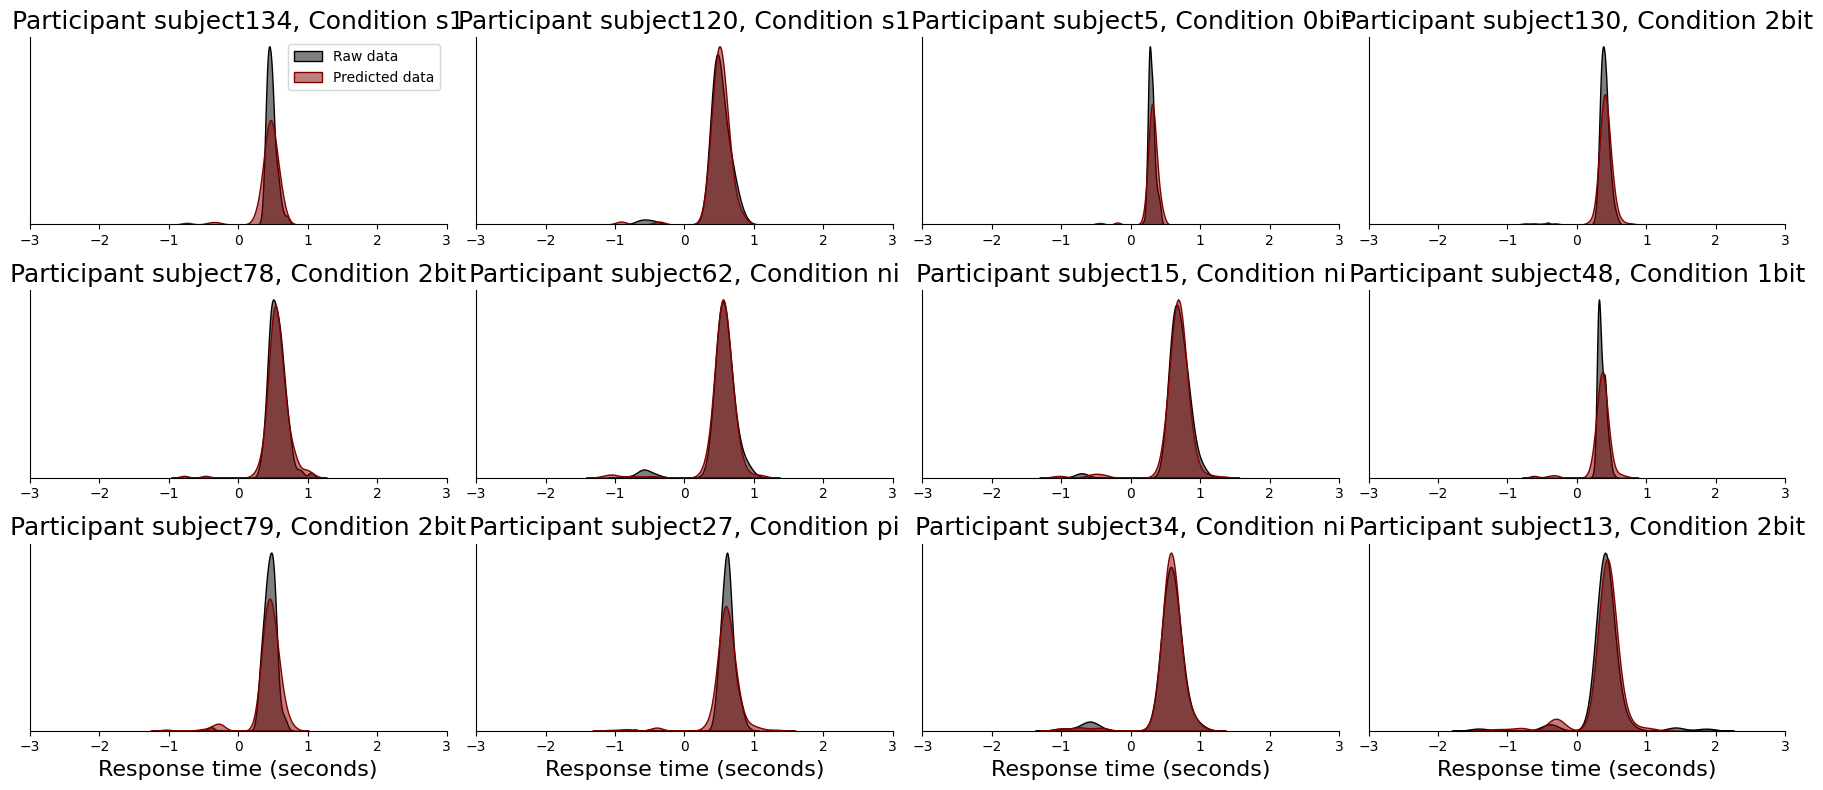

In [24]:
# Sample 12 rows from PAR
indices = PAR.sample(12)

f, axarr = plt.subplots(3, 4, figsize=(18, 8))

# Iterate over the sampled rows
for i, (idx, index) in enumerate(indices.iterrows()):
    task = index['task']
    condition = index['condition']
    sub = index['sub']

    raw_data = pd.read_csv(path_to_data + task + '/condition_' + str(condition) + '/' + task + '_data_' + str(sub) + '.csv')
    raw_data["rt"] = (raw_data["resp"]*2 - 1) * raw_data["rt"]
    condition_num = raw_data["resp"]*0
    data = np.c_[condition_num, raw_data["rt"].to_numpy()]

    num_obs = data.shape[0]

    # Re-simulate
    pred_data = LF_experiment(index.iloc[3:8].to_numpy(), num_obs)

    ax = axarr.flat[i]
    sns.kdeplot(
        data[:, 1], ax=ax, fill=True, color="black", alpha=0.5, label="Raw data"
    )
    sns.kdeplot(pred_data[:, 1].flatten(), ax=ax, fill=True, color="maroon", alpha=0.5, label="Predicted data")
    ax.set_xlim((-3, 3))
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Participant {sub}, Condition {condition}", fontsize=18)

    # Set legend to first plot
    if i == 0:
        ax.legend()

    # Set x label to bottom row
    if i > 7:
        ax.set_xlabel("Response time (seconds)", fontsize=16)
    sns.despine()

f.tight_layout()